In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
from utils.utils import MyDataset, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from sklearn.decomposition import PCA
import matplotlib
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

In [3]:
train_dataset = MyDataset(root='../../data/complete_random/hetero_1/Sub20x20_full_grid.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float
))

In [9]:
latent_dims = 256
capacity = latent_dims//2
input_size = 20
epochs = 100
sigmoid = False
instance = "hetero_1"
lr1 = 1e-3
params = {
    "input_size": input_size,
    "latent_dims": latent_dims,
    "capacity": capacity,
    "epochs": epochs,
    "sigmoid": sigmoid,
    "instance": instance,
    "lr1": lr1,
}
net = FireAutoencoder(params)
net.load_state_dict(torch.load(f'../weights/hetero_1/AE/sub20x20_latent={latent_dims}_capacity={capacity}_{epochs}_sigmoid={sigmoid}_T1=100_T2=100_lr1={lr1}_lr2=0.0001_lr3=0.0001_normalize=False_weight_decay=0.pth', map_location=torch.device('cpu') ))

<All keys matched successfully>

In [10]:
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 4336641


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

In [12]:
images, r = next(iter(train_loader))

Original images


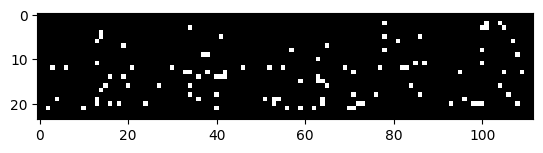

In [13]:
print('Original images')
show_image(torchvision.utils.make_grid(images[0:5],5))
plt.show()

Reconstruction:


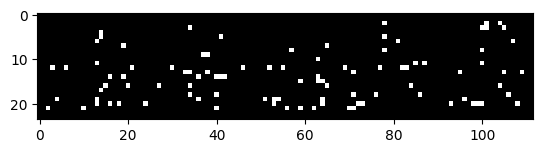

In [16]:
print('Reconstruction:')
visualise_output(images, r, net, 5, 5)

In [17]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [32]:
all_images, all_r = next(iter(full_loader))

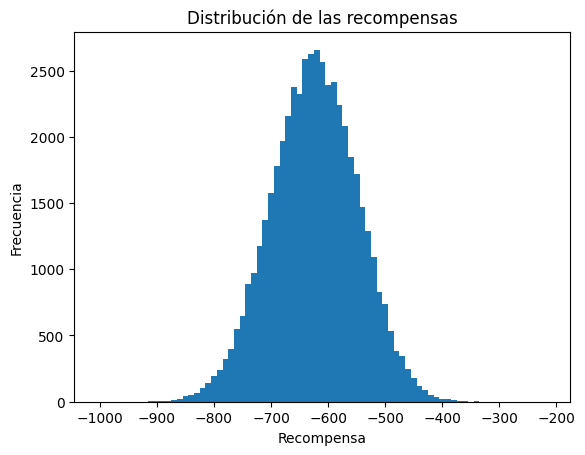

In [33]:
bins = np.arange(-1000, -200, 10)
plt.hist(all_r, bins=bins, align='left')
plt.title('Distribución de las recompensas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
plt.savefig(f"reward_distr.png")
plt.show()

In [27]:
encoded_images = net.encode(all_images)

In [35]:
all_r.apply_(lambda x: 2 if x > -500 else 1 if (x > -700) else 0)

tensor([0., 0., 1.,  ..., 1., 1., 1.])

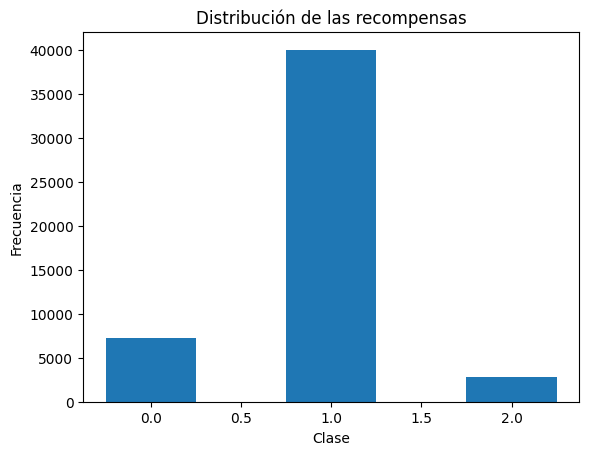

In [36]:
bins = np.arange(0, 3, 0.5)
plt.hist(all_r, bins=bins, align='left')
plt.title('Distribución de las recompensas')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.savefig(f"reward_classes_distr.png")
plt.show()

In [37]:
pca = PCA(n_components=3)
with torch.no_grad():
    encoded_3d_pca = pca.fit_transform(encoded_images)

In [38]:
colors = ['green', 'blue', 'red']
classes = ['small', 'medium', 'large']

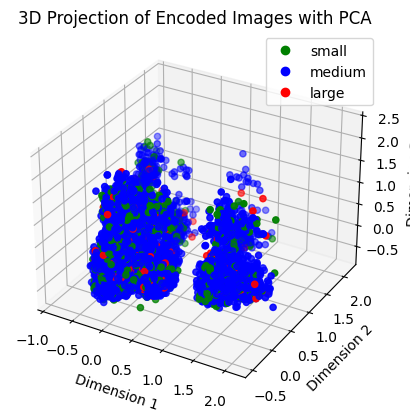

In [40]:
# Create a 3D scatter plot of the 3D representations
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(encoded_3d_pca[:, 0], encoded_3d_pca[:, 1], encoded_3d_pca[:, 2],c=all_r, cmap=matplotlib.colors.ListedColormap(colors))

ax.set_title('3D Projection of Encoded Images with PCA')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
#plt.savefig(f"latent_space/homo_2_sub20x20_pca_latent={latent_dims}_capacity={capacity}_{epochs}.png")
plt.show()

In [23]:
tsne = TSNE(n_components=3)
with torch.no_grad():
    encoded_3d_tsne = tsne.fit_transform(encoded_images)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(encoded_3d_tsne[:, 0], encoded_3d_tsne[:, 1], encoded_3d_tsne[:, 2],c=all_r, cmap=matplotlib.colors.ListedColormap(colors))

ax.set_title('3D Projection of Encoded Images with TSNE')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig(f"latent_space/homo_2_sub20x20_tsne_latent={latent_dims}_capacity={capacity}_{epochs}.png")
plt.show()

In [79]:
umap_model = umap.UMAP(n_components=3)

In [80]:
with torch.no_grad():
    encoded_3d_umap = umap_model.fit_transform(encoded_images)

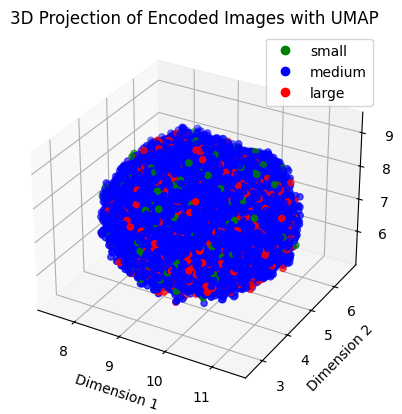

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
scatter = ax.scatter(encoded_3d_umap[:, 0], encoded_3d_umap[:, 1], encoded_3d_umap[:, 2],c=all_r, cmap=matplotlib.colors.ListedColormap(colors))

ax.set_title('3D Projection of Encoded Images with UMAP')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig(f"latent_space/homo_2_sub20x20_umap_latent={latent_dims}_capacity={capacity}_{epochs}.png")
plt.show()

In [18]:
f = open("train_stats/test_losses.txt", "r")
a = f.read()

In [19]:
latent_dims = []
test_losses = []
for a in a.split('\n')[:-1]:
    latent_dims.append(int(a.split(',')[0]))
    test_losses.append(float(a.split(',')[2]))

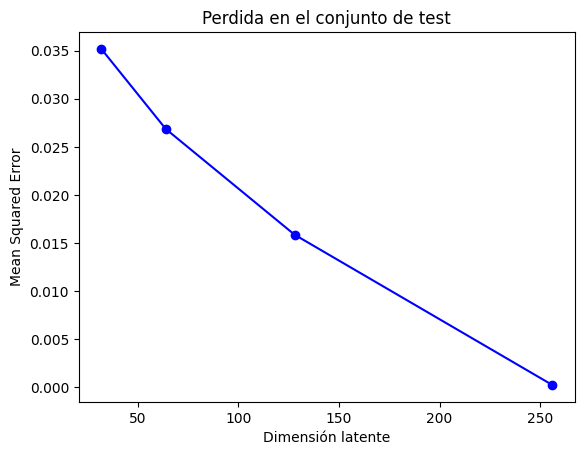

In [20]:
plt.plot(latent_dims,test_losses, marker='o', color='b'
)
plt.title("Perdida en el conjunto de test")
plt.xlabel("Dimensión latente")
plt.ylabel("Mean Squared Error")
plt.savefig(f"train_stats/test_loss_compare.png")
plt.show()
